# microDCGAN

### Input parameters
Set folder paths for input and output data and choose parameters for training

In [1]:
architecture = 'DCGAN'                                   # Neural network architecture: 'GAN' or 'DCGAN'

path_input = '../GAN_2D_Data/input_128x128_center'       # Absolute or relative location of real input images for training
path_output = '../GAN_2D_Data/output_128x128'            # Absolute or relative location of folder where generated images and plots are saved to

note = 'scans1and2_test'                                 # Custom suffix which is part of the filenames

size_input = 128                                         # Pixel size of input images (square). Currently no resize operations in this code, use already resized images!

format_input = '.jpg'                                    # Format of input images
format_output = '.jpg'                                   # Format of output images

### Parameters ########################
batch_size             = 128                             # Number of training images per batch. Total number of training batches loaded = (Number of input images / batch_size)
num_epochs             = 100                             # Number of training epochs (complete passes through the training dataset)
lr_generator           = 0.00005                         # Generator learn rate
lr_discriminator       = 0.00005                         # Discriminator learn rate
betas = (0.5, 0.999)                                     # Adam optimizer coefficients for computing running averages of gradient and its square, the pyTorch default is (0.9, 0.999)
apply_weights          = True                            # Whether to set predefined weights for network layers (can speed up training or lead to instability)
number_gpu             = 1                               # If > 0 the program will automatically try to run the computation using device 'cuda'
number_workers         = 0                               # Number of workers for DataLoader (subprocesses to handle data loading), default: 0 (only main process)
######################################

### Experimental #####################
ks                     = 4                               # Kernel size in DCGAN, kernel size different from 4 will lead to other image sizes (Additional changes in code needed)
######################################

### Checkpoint #######################                   # Not tested with multi-GPU
load_checkpoint = False                                   # If True searches for *.pt file in input(!) directory, loads checkpoint if available and resumes training at given epoch
name_checkpoint_load = 'checkpoint.pt'                   # Name of *.pt file that will be loaded 
name_checkpoint_save = 'checkpoint.pt'                   # Name of new checkpoint that will be saved (same name as name_checkpoint_load will overwrite existing checkpoint!)
######################################

random_seed = 112                                        # Set seed for reproducibility of random operations (shuffle, random noise, ...)

font_size = 22                                           # Font size for LaTex plots

DCGAN_128x128_bs128_lrG00005_lrD00005_ks4_e100_scans1and2_test


Get the output filename (composed of parameters and suffix)

In [ ]:
name_output = f'{architecture}_{size_input}x{size_input}_bs{batch_size}_lrG{"{:f}".format(lr_generator).rstrip("0").split(".")[1]}_lrD{"{:f}".format(lr_discriminator).rstrip("0").split(".")[1]}_ks{ks}_e{num_epochs}_{note}'
print(name_output)

Import all necessary packages

In [2]:
import models_1 as models                                                   # Python file containing the network architectures for generator and discriminator (needs to be in the same directory!)

import torch
import torch.nn as nn                       
# import torchvision
# import torchvision.transforms as transforms
from torchvision import transforms
from torch.utils.data import DataLoader
# import torchvision.datasets as dset
import torchvision.utils as vutils
# from torchvision import datasets

from torchinfo import summary                                       # Displays a TensorFlow-like summary of the initialised model

# import SimpleITK as sitk    
from glob import glob
import numpy as np
import os

import signal
import sys
# import time
# import threading
import datetime
from datetime import datetime
# from datetime import date

import csv
import cv2

from PIL import Image        # Python Imaging Library to load the real input images

import matplotlib.pyplot as plt
# import matplotlib as mpl

%matplotlib inline
from IPython import display
from IPython.display import clear_output

from tqdm.notebook import tqdm      # To show a progress bar

import warnings     # Sometimes needed to supress some insignificant warnings

#import ignite
from torchmetrics.image.fid import FrechetInceptionDistance         
from torchmetrics import StructuralSimilarityIndexMeasure

# print(*map(lambda m: ": ".join((m.__name__, m.__version__)), (torch, torchvision, ignite)), sep="\n")
# mpl.rcParams['text.usetex'] = True # Use local LaTex for plot text rendering

### Utilities

##### Text and Print

In [4]:
def print_write(text, file):
    '''
    Function to print text to console output and write to a specified file simultaneously.
    To be used inside 
    
        with open(path, mode, encoding="utf-8") as file:
            print_write(text, file)
    
    Parameters
    ----------
    text: str
        Contains the information
    file: str
        Name of opened file
    '''
    print(text)
    file.write(text + '\n')

##### LaTex 

In [5]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams.update({'font.size': font_size})

##### CSV

In [6]:
def to_csv(name, array):
    '''
    Function to save array in a new .csv file.

    Parameters
    ----------
    path: str
        Name of File in current working directory or path to file in different directory
    list: list
        List containing the data
    '''
    with open(name, 'w') as file:
        # using csv.writer method from CSV package
        write = csv.writer(file)
        
        write.writerow(array)

### Initialization
Initialise GPU (Nvidia CUDA) if available to use for training instead of CPU (GPU is significantly faster)

In [1]:
device = "cuda" if torch.cuda.is_available() and number_gpu > 0 else "cpu"

print(f"Running computation on device: {device}")

# print(torch.get_num_threads())
# torch.set_num_interop_threads()     # Inter-op parallelism for cpu
# torch.set_num_threads(10)           # Intra-op parallelism for cpu

NameError: name 'torch' is not defined

Set random seed for reproducibility of results

In [8]:
torch.manual_seed(random_seed);

### Load and process input

##### Transformation

Define a function to normalize input data and transform it to pyTorch tensor

In [9]:
# Create a list of transformations
transforms = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

print('Applying the following transformations:\n\n' + str(transforms))

Applying the following transformations:

Compose(
    ToTensor()
    Normalize(mean=(0.5,), std=(0.5,))
)


Load the real image dataset from input folder

In [10]:
train_set = []      # Initialize empty list to contain all input images (and their corresponding labels)
label = 0           # All real input images will be labeled '0' >>> Why not 1 (== TRUE)??? Maybe change later... Labels currently not used at all!!!

for file in (pbar := tqdm(glob(f'{path_input}/*{format_input}'), desc='Loading images from directory')):                   # Get training data from specified folder
    img = Image.open(file)                      # Use PIL to load images
    img_tensor = transforms(img)                # Apply the transformations defined above, 'torch.Size([1, size_input, size_input])' with only one color channel (gray image)
    train_set.append((img_tensor, label))       # Append tupel ( , )

../GAN_2D_Data/input_128x128_center/*.jpg


Loading images from directory:   0%|          | 0/7320 [00:00<?, ?it/s]

Distribute images from the training dataset into batches

In [11]:
# Divide the train set into multiple shuffled batches
# 'drop_last=True' ensures that no partially filled batches are generated 
# (if number of images != integer multiple of batch size, the remaining images are ignored)

train_loader = DataLoader(
    train_set, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=number_workers
)

print(f'Total number of batches from DataLoader: {len(train_loader)}')

# Display the first batch (exemplary)

# real_batch = next(iter(train_loader))
# plt.figure(figsize=(20, 40))
# plt.axis("off")
# plt.title("Training Images (example batch)")
# plt.imshow(vutils.make_grid(real_batch[0].to(device)[:], padding=5, normalize=True, nrow=8, pad_value=1.0).cpu().permute(1,2,0));  

Total number of batches from DataLoader: 57


### Evaluation
##### Frechet Inception Distance 

In [12]:
# %%time

# Choose the inceptionv3 feature layer (64, 192, 768 or 2048)
fid = FrechetInceptionDistance(feature=2048, reset_real_features=False, normalize=True).to(device=device)

# Update the pretrained model with real validation data
for batch in tqdm(train_loader, desc='Training Inception v3 network for FID calculation'):
    fid.update(batch[0].to(device).repeat(1,3,1,1), real=True)     # batch[0] contains the images whereas batch[1] contains the labels                     

def FID(fake):
    '''
    Function to calculate the FID for fake images with pretrained inceptionv3 network
    '''
    fid.reset()                                          # Resets all fake features (reset_real_features=False) 
    fid.update(fake.repeat(1,3,1,1), real=False)
    return fid.compute().item()

Training Inception v3 network for FID calculation:   0%|          | 0/57 [00:00<?, ?it/s]

CPU times: user 3.43 s, sys: 1.47 s, total: 4.9 s
Wall time: 28.6 s


##### Structural Similarity Index Measure

In [1]:
ssim = StructuralSimilarityIndexMeasure(data_range=1.0)

NameError: name 'StructuralSimilarityIndexMeasure' is not defined

In [15]:
################################################################## write to the start of notebook
nz = 100 # Size of z latent vector (i.e. size of generator input)
features_g = 64  # Size of feature maps in generator                                                           
features_d = 64  # Size of feature maps in generator
img_channels = 1 # Number of channels in image
stride=2         # Stride of kernel in convolutional layers
##################################################################

In [16]:
# Load network architecture from external python file
if architecture == 'GAN':
    
    generator = models.GAN_Generator().to(device=device)
    print('\n=== GENERATOR ============================================================================\n')
    print(generator)
    print(summary(generator, input_size = (batch_size, 100)))
    
    discriminator = models.GAN_Discriminator().to(device=device)
    print('\n\n=== DISCRIMINATOR ========================================================================\n')
    print(discriminator)
    print(summary(discriminator, input_size=(batch_size, 1, size_input, size_input)))
    
elif architecture == 'DCGAN':
   
    generator = models.DCGAN_Generator(img_channels, features_g).to(device=device)
    print('\n=== GENERATOR ============================================================================\n')
    print(generator)
    try:
        print(summary(generator, input_size = (batch_size, 100, 1, 1)))
    except:
        pass
    
    discriminator = models.DCGAN_Discriminator(img_channels, features_d).to(device=device)
    print('\n\n=== DISCRIMINATOR ========================================================================\n')
    print(discriminator)
    try:
        print(summary(discriminator, input_size=(batch_size, 1, size_input, size_input)))
    except:
        pass


# Enable GPU parallelization
if (device == 'cuda') and (number_gpu > 1):
    
    generator = nn.DataParallel(generator, list(range(number_gpu)))
    discriminator = nn.DataParallel(discriminator, list(range(number_gpu)))


=== GENERATOR ============================================================================

DCGAN_Generator(
  (model): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(2, 2), bias=False)
      (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (3): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=

/pfs/data5/home/kit/iam-wk/gl3129/2DGAN_env/lib/python3.9/site-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type:depth-idx)                   Output Shape              Param #
DCGAN_Discriminator                      [128, 1]                  --
├─Sequential: 1-1                        [128, 1, 1, 1]            --
│    └─Conv2d: 2-1                       [128, 64, 64, 64]         1,024
│    └─LeakyReLU: 2-2                    [128, 64, 64, 64]         --
│    └─Sequential: 2-3                   [128, 128, 32, 32]        --
│    │    └─Conv2d: 3-1                  [128, 128, 32, 32]        131,072
│    │    └─BatchNorm2d: 3-2             [128, 128, 32, 32]        256
│    │    └─LeakyReLU: 3-3               [128, 128, 32, 32]        --
│    └─Sequential: 2-4                   [128, 256, 16, 16]        --
│    │    └─Conv2d: 3-4                  [128, 256, 16, 16]        524,288
│    │    └─BatchNorm2d: 3-5             [128, 256, 16, 16]        512
│    │    └─LeakyReLU: 3-6               [128, 256, 16, 16]        --
│    └─Sequential: 2-5                   [128, 512, 8, 8]          --


### Weight Initialization

In [18]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
        
if apply_weights:
    generator.apply(weights_init)
    discriminator.apply(weights_init)

### Loss functions and Optimizer
Adam Optimizer

In [19]:
loss_function = nn.BCELoss()        # Binary Cross Entropy

optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr_generator, betas=betas)
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr_discriminator, betas=betas)

Function that generates noise samples as generator input

In [20]:
def noise(batch_size, size):
    '''
    Generates a tensor filled with gaussian sampled random values (float) between 0 and 1
    '''
    if architecture == 'GAN':
        return torch.randn((batch_size, size)).to(device=device)    # torch.Size([batch_size, 100])
    elif architecture == 'DCGAN':
        return torch.randn((batch_size, size, 1, 1)).to(device=device)    # torch.Size([batch_size, 100, 1, 1])
    
# Fixed random seed for visualization of training progress
fixed_noise = noise(batch_size, 100)  

### Training
Create empty lists to save progress during training

In [21]:
img_list = []       # Save generated image batch (not already grid due to computation time) of every epoch to show animation/video later
G_losses = []       # Save generator and discriminator loss for plot options       --> change plot to start at 1 instead of adding value 0
D_losses = []
D_losses_real = []
D_losses_fake = []
FID_list = []
iterations = 0      # Iteration counter
epochs = 0          # Epoch counter

score_real = []
score_fake = []
score_disc = []
#img_generated = []

live_progress = True    # Disable for (much!) faster calculation, enable for live update of image quality and loss plot
intervall = 50          # Intervall for live progress and animation (for after computation)

### Search for checkpoint file (*.pt) to load training progress and additional training information 
Not yet tested for multi-GPU training!

In [ ]:
if load_checkpoint:
    try:
        print('Trying to load model checkpoint from file...')
        checkpoint = torch.load(f'{path_input}/{name_checkpoint_load}')
        epochs = checkpoint['epoch']
        generator.load_state_dict(checkpoint['generator_state_dict'])
        optimizer_generator.load_state_dict(checkpoint['optimizer_generator_state_dict'])
        G_losses = checkpoint['generator_losses']
        discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
        optimizer_discriminator.load_state_dict(checkpoint['optimizer_discriminator_state_dict'])
        D_losses = checkpoint['discriminator_losses']
        print(f'Resume training at epoch {epochs}')

        generator.train()
        discriminator.train()

    except Exception as e:
        print(e)
        #print('No checkpoint file (.pt) found. Starting training at epoch one...')

In [22]:
def job_summary(status, t_start, t_end):
    with open(path_output+'/'+name_output+'_job_summary.log', 'w') as file:
        print('\n\n')
        print_write('=== COMPUTATION SUMMARY ==================================================================', file)
        print_write(f'Status:        {status}', file)
        print_write(f'Start:         {t_start.replace(microsecond=0)}', file)
        print_write(f'Stop:          {t_end.replace(microsecond=0)}', file)
        print_write(f'Duration:      {str(t_end-t_start).split(".")[0]}', file)
        print_write('------------------------------------------------------------------------------------------', file)
        print_write(f'Architecture:  {architecture}', file)
        print_write(f'Epochs:        {epochs}', file)
        print_write(f'Batches/Epoch: {len(train_loader)}', file)
        print_write(f'Batch size:    {batch_size}', file)
        print_write(f'Iterations:    {iterations}', file)
        print_write('==========================================================================================', file)

Number of epochs: 100
Number of batches per epoch: 57
Number of images per batch: 128


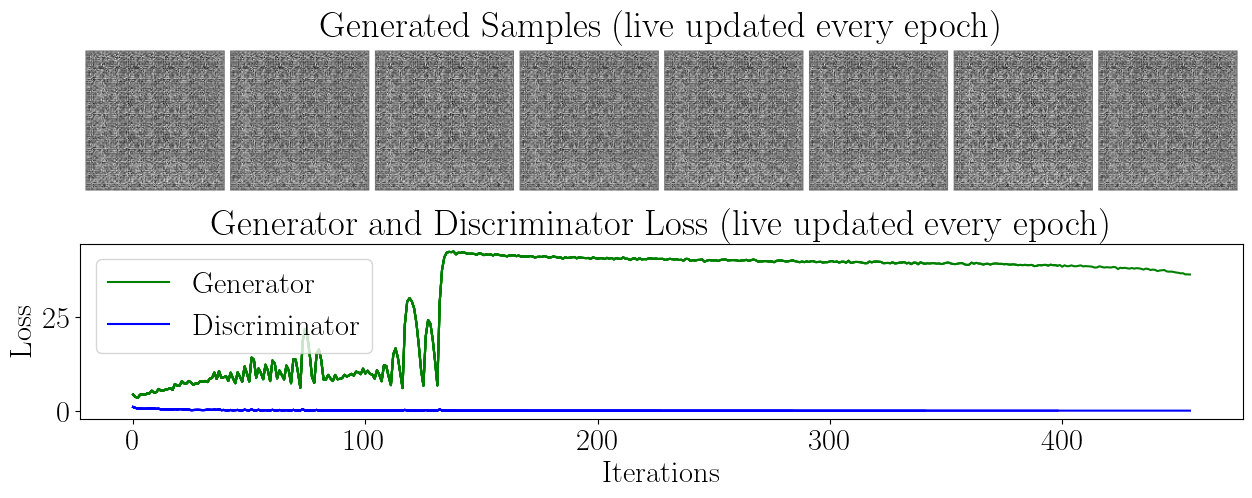

Total Progress:   0%|          | 0/100 [00:00<?, ?it/s, Batch 0/57]


>>> Job aborted after 472 iterations <<<



=== COMPUTATION SUMMARY ==================================================================
Status:        manually aborted
Start:         2023-07-29 15:32:14
Stop:          2023-07-29 15:35:19
Duration:      0:03:04
------------------------------------------------------------------------------------------
Architecture:  DCGAN
Epochs:        8
Batches/Epoch: 57
Batch size:    128
Iterations:    472


SystemExit: Cell execution (manually) stopped

/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3468: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


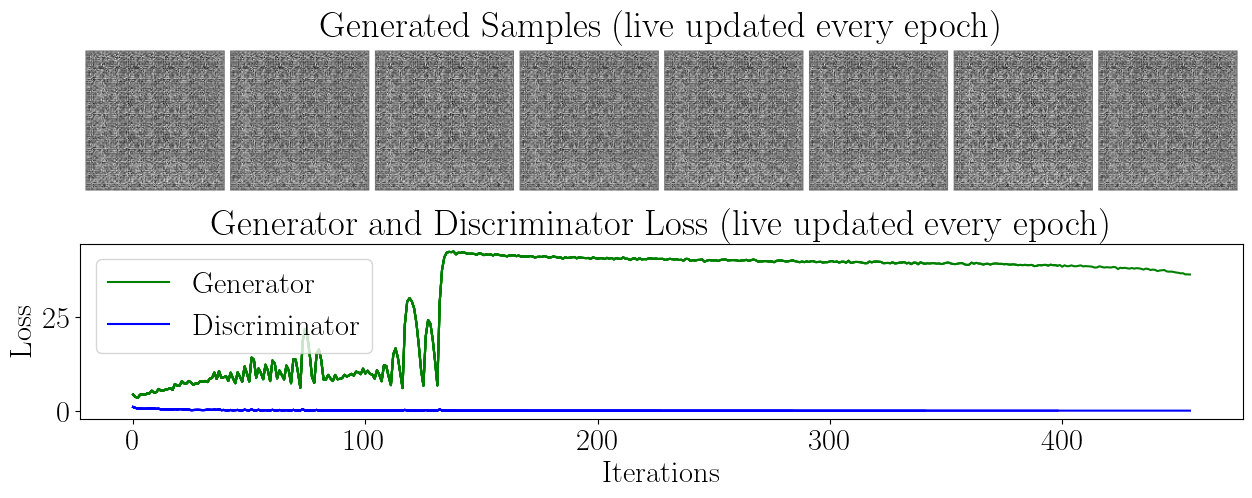

In [23]:
print(f"Number of epochs: {num_epochs}\nNumber of batches per epoch: {len(train_loader)}\nNumber of images per batch: {batch_size}")
    
# Initialize plots
if live_progress:
    # Live plot (continually updated) 

    # Initialize plot to update during training
    fig,ax = plt.subplots(2,1, figsize=(15, 5))  

    # Display generated image examples of last iteration
    ax[0].set_title(f'Generated Samples (live updated every epoch)')
    ax[0].axis('off')
    ax[0].imshow(np.transpose(vutils.make_grid(torch.ones((8, 1, size_input, size_input)), padding=5, normalize=True, nrow=8, pad_value=1.0).cpu(),(1,2,0)))     # Update the live image with newly generated samples
    
    # Display plot of generator and discriminator loss functions
    ax[1].set_title('Generator and Discriminator Loss (live updated every epoch)')
    ax[1].set_ylabel('Loss')
    ax[1].set_xlabel('Iterations')

    hdisplay = display.display('', display_id=True)         # Connect to display to update contents later 
    hdisplay.update(fig)

    def live_plot():
        # Function to update the plot

        ax[0].imshow(vutils.make_grid(fixed_generated_samples.to(device)[:8], padding=5, normalize=True, nrow=8, pad_value=1.0).cpu().permute(1,2,0))     # Update the live image with newly generated samples

        ax[1].plot(G_losses, label="Generator" if epoch == 0 else "", color="green")        # Use if statement to not show duplicate labels each time the plot is updated
        ax[1].plot(D_losses, label="Discriminator" if epoch == 0 else "", color="blue")     

        ax[1].legend(loc="upper left")
        
        hdisplay.update(fig)        # Update the displayed figure


def signal_handler(signal, frame):      
    print(f'\n>>> Job aborted after {iterations} iterations <<<')
    time_stop = datetime.now()
    job_summary('\33[33mmanually aborted\033[0m', time_start, time_stop)
    sys.exit('Cell execution (manually) stopped')

signal.signal(signal.SIGINT, signal_handler)        # Catch error if execution is interupted



################################################################################################################################################################################################
### Main training routine ######################################################################################################################################################################

time_start = datetime.now()    # Get start time for training process ('start stopwatch')     

# For number of epochs do...
for epoch in (pbar_epoch := tqdm(range(num_epochs), desc="Total Progress", postfix=f'Batch 0/{len(train_loader)}')):
    
    # For number of batches in one epoch do...
    for n, (real_samples, _ ) in enumerate(train_loader):  
        # Data for training the discriminator

        real_samples = real_samples.to(device=device)       
        real_samples_labels = torch.ones((batch_size, 1)).to(device=device)

        # Generate noise vector
        latent_space_samples = noise(batch_size, 100)
        generated_samples = generator(latent_space_samples)                  
        generated_samples_labels = torch.zeros((batch_size, 1)).to(device=device)

        ############################
        # Update discriminator 
        ###########################

        discriminator.zero_grad()

        discriminator_output_real = discriminator(real_samples)
        loss_disc_real = loss_function(discriminator_output_real, real_samples_labels)
        discriminator_output_fake = discriminator(generated_samples)
        loss_disc_fake = loss_function(discriminator_output_fake, generated_samples_labels)

        loss_discriminator = (loss_disc_real+loss_disc_fake)/2
        loss_discriminator.backward()       
        optimizer_discriminator.step()
        
        # Data for training the generator
        latent_space_samples = noise(batch_size, 100)

        ############################
        # Update generator
        ###########################
        generator.zero_grad()
        
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated_1 = discriminator(generated_samples)
        loss_generator_1 = loss_function(output_discriminator_generated_1, real_samples_labels)
        
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated_2 = discriminator(generated_samples)
        loss_generator_2 = loss_function(output_discriminator_generated_2, real_samples_labels)
        
        loss_generator = (loss_generator_1+loss_generator_2)/2
        
        loss_generator.backward()
        optimizer_generator.step()



        # Save losses of this iteration into array
        G_losses.append(loss_generator.item())
        D_losses.append(loss_discriminator.item())
        D_losses_real.append(loss_disc_real.item())
        D_losses_fake.append(loss_disc_fake.item()) 
        
        pbar_epoch.set_postfix_str(f'Batch {n+1}/{len(train_loader)}')

        # Keep track of the number of iterations
        iterations += 1     
    
    # Save generated images and additional information of this epoch into array
    fixed_generated_samples = generator(fixed_noise)
    img_list.append(fixed_generated_samples.detach().cpu())
    FID_list.append(FID(generated_samples.detach()))       # Calcute FID once after every epoche

    # Update the live progress plot
    if live_progress:
        live_plot() 

    # Keep track of the number of epochs
    epochs +=1

# Get end time for training process ('stop stopwatch')      
time_stop = datetime.now()

# Print and save summary of training
job_summary('\33[32mcompleted\033[0m', time_start, time_stop)

# Close live plot to avoid displaying duplicates
if live_progress:        
    plt.close(fig)        

#### Save training results

In [ ]:
to_csv(path_output+'/'+name_output+'_loss_generator.csv', G_losses)
to_csv(path_output+'/'+name_output+'_loss_discriminator.csv', D_losses)
to_csv(path_output+'/'+name_output+'_loss_disc_real.csv', D_losses_real)
to_csv(path_output+'/'+name_output+'_loss_disc_fake.csv', D_losses_fake)
to_csv(path_output+'/'+name_output+'_FID.csv', FID_list)


### Save model training progress and relevant training information in checkpoint file (*.pt) using python dictionary structure 

In [ ]:
torch.save({
            'epoch': epochs,
            'generator_state_dict': generator.state_dict(),
            'optimizer_generator_state_dict': optimizer_generator.state_dict(),
            'generator_losses': G_losses,
            'discriminator_state_dict': discriminator.state_dict(),
            'optimizer_discriminator_state_dict': optimizer_discriminator.state_dict(),
            'discriminator_losses': D_losses,
            'progress': img_list,
            }, f'{path_output}/{name_checkpoint_save}')

### Plots

In [ ]:
fig, ax1 = plt.subplots(figsize=(30, 10))
ax1.plot(range(1, len(D_losses_real)+1, 1), D_losses_real, label="Loss real", color="blue")  
ax1.plot(range(1, len(D_losses_fake)+1, 1), D_losses_fake, label="Loss fake", color="red")        
ax1.set_title('Discriminator Loss')
ax1.legend(loc="upper right")
ax1.set_xlabel("Iterations")
ax1.set_ylabel("Loss")
#ax1.legend(loc="upper right")

ax2 = ax1.twiny()                       # Add second axis
ax2.xaxis.set_ticks_position('bottom') # set the position of the second x-axis to bottom
ax2.xaxis.set_label_position('bottom') # set the position of the second x-axis to bottom
ax2.spines['bottom'].set_position(('outward', 70))
ax2.set_xlabel('Epochs')
ax2.set_xlim(ax1.get_xlim())

x_ticks = np.arange(0, epochs+1, 20)
#newpos   = [t for t in newlabel]   # position of the xticklabels in the old x-axis
ax2.set_xticks(x_ticks*len(train_loader))
ax2.set_xticklabels(x_ticks)

props = dict(boxstyle='round', facecolor = 'wheat', alpha = 0.5)
plt.text(.01, .97, f'batch size: {batch_size}\nlearn rate generator: {lr_generator}\nlearn rate discriminator: {lr_discriminator}', fontsize=22, transform = ax1.transAxes, verticalalignment='top', bbox=props)

# print((D_losses_real[0]+D_losses_fake[0])/2)
plt.plot()
plt.savefig(path_output+'/'+name_output+'_loss_real_fake.png', dpi=250, bbox_inches='tight')
plt.savefig(path_output+'/'+name_output+'_loss_real_fake.eps', format='eps', bbox_inches='tight')

#### Loss functions

In [ ]:
fig, ax1 = plt.subplots(figsize=(30, 10))
ax1.plot(range(1, len(G_losses)+1, 1), G_losses, label="Generator" , color="green")        # use if statement to not show duplicates at each iteration
ax1.plot(range(1, len(D_losses)+1, 1), D_losses, label="Discriminator", color="blue")     # markplt.legend(loc="upper right")
ax1.set_title('Generator and Discriminator Loss')
ax1.set_xlabel("Iterations")
ax1.set_ylabel("Loss")
ax1.legend(loc="upper right")
ax2 = ax1.twiny()                       # Add second axis
ax2.xaxis.set_ticks_position('bottom') # set the position of the second x-axis to bottom
ax2.xaxis.set_label_position('bottom') # set the position of the second x-axis to bottom
ax2.spines['bottom'].set_position(('outward', 70))
ax2.set_xlabel('Epochs')
ax2.set_xlim(ax1.get_xlim())

x_ticks = np.arange(0, epochs+1, 20)
#newpos   = [t for t in newlabel]   # position of the xticklabels in the old x-axis
ax2.set_xticks(x_ticks*len(train_loader))
ax2.set_xticklabels(x_ticks)

props = dict(boxstyle='round', facecolor = 'wheat', alpha = 0.5)
plt.text(.01, .97, f'batch size: {batch_size}\nlearn rate generator: {lr_generator}\nlearn rate discriminator: {lr_discriminator}', fontsize=22, transform = ax1.transAxes, verticalalignment='top', bbox=props)

plt.plot()
plt.savefig(path_output+'/'+name_output+'_losses.png', dpi=250, bbox_inches='tight')
plt.savefig(path_output+'/'+name_output+'_losses.eps', format='eps', bbox_inches='tight')

### !!! plot starts at iteration 0 (manually added)???

#### Frechet Inception Distance

In [ ]:
fig, ax1 = plt.subplots(figsize=(30, 10))
ax1.plot(range(1, len(FID_list)+1, 1), FID_list, label="FID" , color="black")        
ax1.set_title('Fréchet Inception Distance (FID)')
ax1.set_xlabel("Epochs")
ax1.set_ylabel("FID")
#ax1.legend(loc="upper right")

props = dict(boxstyle='round', facecolor = 'wheat', alpha = 0.5)
plt.text(.01, .97, f'batch size: {batch_size}\nlearn rate generator: {lr_generator}\nlearn rate discriminator: {lr_discriminator}', fontsize=22, transform = ax1.transAxes, verticalalignment='top', bbox=props)


plt.plot()
plt.savefig(path_output+'/'+name_output+'_FID.png', dpi=250)
plt.savefig(path_output+'/'+name_output+'_FID.eps', format='eps')

Show last batch of generated images

In [ ]:
# plt.figure(figsize=(30, 30))
# plt.axis("off")
# plt.title("Generated Images (fake, last batch)")
# plt.imshow(vutils.make_grid(generated_samples.to(device), padding=5,  normalize=True, nrow=8, pad_value=1.0).cpu().permute(1,2,0)) 

In comparison to real input images

In [ ]:
# real_batch = next(iter(train_loader))
# plt.figure(figsize=(30, 30))
# plt.axis("off")
# plt.title("Training Images (ground truth, example batch)")
# plt.imshow(vutils.make_grid(real_batch[0].to(device)[:], padding=5, normalize=True, nrow=8, pad_value=1.0).cpu().permute(1,2,0))
# plt.show()

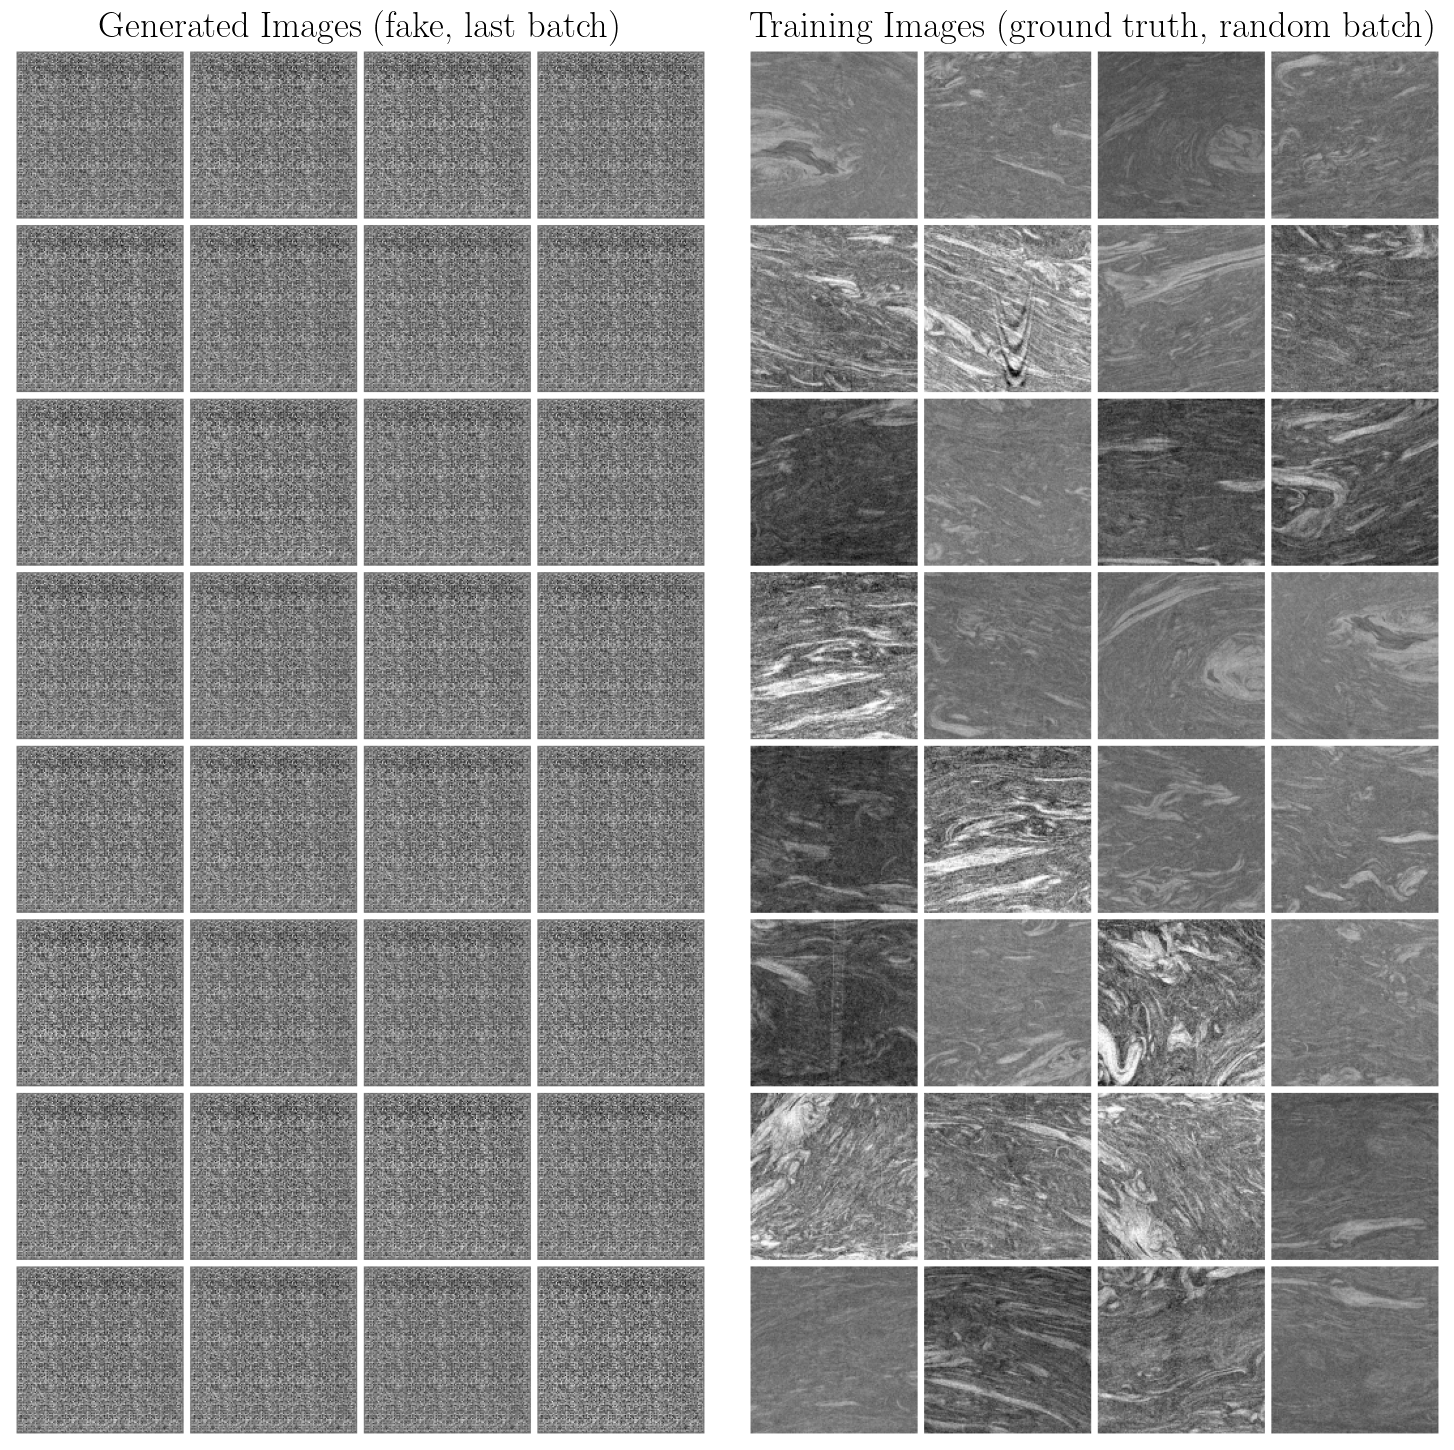

In [24]:
#%%time
real_batch = next(iter(train_loader))

fig, ax = plt.subplots(1, 2, figsize=(15, 30))
k = 32
ax[0].imshow(vutils.make_grid(generated_samples[:k], padding=5,  normalize=True, nrow=4, pad_value=1.0).cpu().permute(1,2,0))
ax[0].set_title('Generated Images (fake, last batch)')
ax[0].axis('off')

ax[1].imshow(vutils.make_grid(real_batch[0][:k], padding=5, normalize=True, nrow=4, pad_value=1.0).cpu().permute(1,2,0))
ax[1].set_title('Training Images (ground truth, random batch)')
ax[1].axis('off')

plt.tight_layout()
#plt.show()
plt.savefig(path_output+'/'+name_output+'_comparison.png', dpi=250, bbox_inches='tight')
plt.savefig(path_output+'/'+name_output+'_comparison.eps', format='eps', bbox_inches='tight')


In [31]:
from torchvision.utils import save_image


for i, image in enumerate(generated_samples):
    save_image(image, f'img{i}.png', normalize=True)

Display the most similar images from training set for visual comparison using simple euklidian distance

In [ ]:
# returns enumerate with index of k nearest neighbours in training set and the corresponding distance value
def get_k_nearest_samples(fake_image, training_images, k=4):
    '''
    Searches for the k-nearest samples in the dataset of a given image based on the euclidean distance.
    '''
    def distance(tensor_a, tensor_b):
        '''
        Calculates the euklidean distance of two torch tensors of the same size.
        '''
        return torch.sqrt(((tensor_a - tensor_b) ** 2).sum())
    
    dist = [distance(fake_image, real_image) for real_image in training_images]
    

    return np.argsort(dist)[:k], np.sort(dist)[:k] # argsort returns the indices that sort the array; index, distance value
    
    
# Get necessary images
train_imgs = [x[0] for x in train_set]     # get array of real images without corresponding label
generated_samples = generated_samples.cpu().detach()


eukl_dist = [(get_k_nearest_samples(generated_samples[i], train_imgs, k=1)[1])[0] for i in tqdm(range(batch_size))]
print(eukl_dist)

### Plot euklidean distance for all images samples in generated batch
fig, ax1 = plt.subplots(figsize=(30, 10))
ax1.plot(np.arange(1, batch_size+1, 1), np.sort(eukl_dist), color="darkorange")        # use if statement to not show duplicates at each iteration
ax1.set_title('Minimum euklidean distance of all images in one batch (sorted)')
ax1.set_xlabel("Image number")
ax1.set_ylabel("Euklidean Distance")

plt.axhline(y=np.mean(eukl_dist), color='black', linestyle='--', label= 'Mean euklidean distance: %.4f (Standard deviation: %.4f)' % (np.mean(eukl_dist), np.std(eukl_dist)))
ax1.legend(loc="upper right")
ax1.grid()
to_csv(path_output+'/'+name_output+'_NN.csv', np.sort(eukl_dist))
plt.savefig(path_output+'/'+name_output+'_nearest_Neighbour.png', dpi=250, bbox_inches='tight')

# print('==========================================================================================')
# print('Mean euklidean distance:', np.mean(eukl_dist))
# print('Standard deviation:', np.std(eukl_dist))
# print('==========================================================================================')

k = 4               # number of nearest neighbours to be displayed
eukl_index = [(get_k_nearest_samples(generated_samples[i], train_imgs, k=k)[0]) for i in range(k+1)]
print(eukl_index)

### Plot nearest neighbours
for i in range (4):
    f, ax = plt.subplots(1,k+1, figsize=(30, 10))
    ax[0].imshow(generated_samples[i].reshape(size_input, size_input), cmap="gray")
    ax[0].set_yticks([])
    ax[0].set_xticks([])
    ax[0].set_title("Generated")
    for axis in ['top', 'bottom', 'left', 'right']:
        ax[0].spines[axis].set_linewidth(2.5)  # change width
        ax[0].spines[axis].set_color('darkorange')    # change color
    
    for j in range(k):
        ax[j+1].imshow(train_imgs[(eukl_index[i])[j]].reshape(size_input, size_input), cmap="gray")  # display only 0,4,8 because otherwise the first images are the same, just augmented (flipped)
        ax[j+1].axis('off')
        ax[j+1].set_title(f"Nearest Neighbour {j+1}")
        
    plt.savefig(path_output+'/'+name_output+f'_nearest_neighbour_{i}.png', dpi=250, bbox_inches='tight')
    plt.savefig(path_output+'/'+name_output+f'_nearest_neighbour_{i}.eps', format='eps', bbox_inches='tight')

SSIM Test

In [ ]:
device = 'cuda'
ssim = StructuralSimilarityIndexMeasure(data_range=1.0, kernel_size=3).to(device)

# preds = torch.rand([3, 3, 256, 256])
# target = preds * 0.70
# ssim(preds, target)

In [ ]:
# returns enumerate with index of k nearest neighbours in training set and the corresponding distance value
def get_k_nearest_samples(fake_image, training_images, k=4):
    '''
    Searches for the k-nearest samples in the dataset of a given image based on the euclidean distance.
    '''
    def distance(tensor_a, tensor_b):
        '''
        Calculates the euklidean distance of two torch tensors of the same size.
        '''
        return ssim(tensor_a.view(1,1,size_input,size_input), tensor_b.view(1,1,size_input,size_input)).cpu()
    
    dist = [distance(fake_image, real_image) for real_image in tqdm(training_images)]
    

    return np.argsort(dist)[::-1][:k], np.sort(dist)[::-1][:k] # argsort returns the indices that sort the array; index, distance value
    
    
# Get necessary images
train_imgs = [x[0].to(device) for x in train_set]     # get array of real images without corresponding label
generated_samples = generated_samples.cpu().detach()


eukl_dist = [(get_k_nearest_samples(generated_samples[i].to(device), train_imgs, k=1)[1])[0] for i in tqdm(range(batch_size))]
print(eukl_dist)

### Plot euklidean distance for all images samples in generated batch
fig, ax1 = plt.subplots(figsize=(30, 10))
ax1.plot(np.arange(1, batch_size+1, 1), np.sort(eukl_dist), color="darkorange")        # use if statement to not show duplicates at each iteration
ax1.set_title('Minimum euklidean distance of all images in one batch (sorted)')
ax1.set_xlabel("Image number")
ax1.set_ylabel("Euklidean Distance")

plt.axhline(y=np.mean(eukl_dist), color='black', linestyle='--', label= 'Mean euklidean distance: %.4f (Standard deviation: %.4f)' % (np.mean(eukl_dist), np.std(eukl_dist)))
ax1.legend(loc="upper right")
#ax1.set_xticks(np.arange(1, batch_size+1, 1.0))
#ax1.set_xlim(1, 24)
ax1.grid()
to_csv(path_output+'/'+name_output+'_NN_SSIM.csv', np.sort(eukl_dist))
plt.savefig(path_output+'/'+name_output+'_nearest_Neighbour_SSIM.png', dpi=250, bbox_inches='tight')

# print('==========================================================================================')
# print('Mean euklidean distance:', np.mean(eukl_dist))
# print('Standard deviation:', np.std(eukl_dist))
# print('==========================================================================================')

k = 4               # number of nearest neighbours to be displayed
eukl_index = [(get_k_nearest_samples(generated_samples[i], train_imgs, k=k)[0]) for i in range(k+1)]
print(eukl_index)


### Plot nearest neighbours
for i in range (4):
    f, ax = plt.subplots(1,k+1, figsize=(30, 10))
    ax[0].imshow(generated_samples[i].reshape(size_input, size_input), cmap="gray")
    ax[0].set_yticks([])
    ax[0].set_xticks([])
    ax[0].set_title("Generated")
    for axis in ['top', 'bottom', 'left', 'right']:
        ax[0].spines[axis].set_linewidth(2.5)  # change width
        ax[0].spines[axis].set_color('darkorange')    # change color
    
    for j in range(k):
        ax[j+1].imshow(train_imgs[(eukl_index[i])[j]].reshape(size_input, size_input), cmap="gray")  # display only 0,4,8 because otherwise the first images are the same, just augmented (flipped)
        ax[j+1].axis('off')
        ax[j+1].set_title(f"Nearest Neighbour {j+1}")
        
    plt.savefig(path_output+'/'+name_output+f'_nearest_neighbour_SSIM_{i}.png', dpi=250, bbox_inches='tight')
    plt.savefig(path_output+'/'+name_output+f'_nearest_neighbour_SSIM_{i}.eps', format='eps', bbox_inches='tight')

#### Save evolution progress visualization (.mp4 video)

In [ ]:
###################################
# Set the text and font properties
font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 0.5
color = (0,0,0)
thickness = 1
###################################

n_img = 32      # Do not show full batch if batch_size is to large

# Load images from img_list and create grid of gray-images
frames = [(vutils.make_grid(frame[:n_img], padding=4, normalize=True, nrow=8, pad_value=1.0)*255) for frame in tqdm(img_list)]    # Generate grids of images from list of image batches


frames = torch.stack(frames, dim=0).permute(0, 2,3,1) # Stack gray (1 channel) to rgb (3 channels) and change order for cv2 module

##############################
#Set video parameters
fps = 10                                    # frames per second
fourcc = cv2.VideoWriter_fourcc(*'mp4v')    # codec
video_size = (frames[0].size(1), frames[0].size(0)+20)                    # size of video (must fit size of frames), +20 for white border at the top
video_writer = cv2.VideoWriter(path_output+'/'+name_output + '_evolution.mp4', fourcc, fps, video_size)
###############################

for epoch, frame in enumerate((pbar := tqdm(frames)), 1):
    
    pbar.set_description("Saving video")

    frame = frame.numpy().astype(np.uint8)                      # Convert to numpy array in uint8 format (converts float values to int)
    frame = np.ascontiguousarray(frame, dtype=np.uint8)         # Seems to be necessary for some reason... (elements are stored in adjacent memory locations that follow a specific order)
    #img = cv2.resize(img, video_size)
    
    text = name_output + ' | '+ str(time_start.replace(microsecond=0)) + ' | Batch Size ' + str(batch_size) + f" | Epoch {epoch}"            # Info text will be displayed at the top of video frame
    frame = cv2.copyMakeBorder(frame, 20, 0, 0, 0, cv2.BORDER_CONSTANT, value=(255,255,255))    # add white border at the top to write on
    cv2.putText(frame, text, (5, 15), font, font_scale, color, thickness)
    video_writer.write(frame)

video_writer.release()